# Evaluation

Evaluation is the process of assessing the performance of a model on a dataset not seen during training. This process can be performed at the end of training or periodically during training to monitor the model's performance. During evaluation, gradients are not computed, and the model is set to evaluation mode to disable features like dropout and batch normalization updates. Below are the typical steps for evaluation.
 - Disable gradient computation.
 - Set the model to evaluation mode.
 - Iterate through the dataset with a DataLoader.
 - Perform a forward pass to compute predictions.
 - Compare predictions to ground truth to compute metrics such as accuracy, precision, recall, etc.

For a more detailed explanation of this topic, you can refer to [this tutorial](../tutorials/cnn/cnn-2.ipynb).

## Metrics

PyTorch does not provide built-in evaluation metrics like accuracy or precision directly. However, we can easily define custom metrics relevant to our tasks. To standardize the evaluation process, we define a base `Metric` class that provides a common interface for all metrics. It includes three methods:

- `reset()` - Clears stored values before a new evaluation run.
- `update(preds, targets)` - Updates the metric with new predictions and target values.
- `compute()`- Computes the final metric result after accumulating values across batches.

The `Metric` class is defined in the [`metrics.py`](../code/metrics.py) file.


### Average metric

Building on this, we define a `Metric` subclass to compute the average of a given metric over multiple batches. The constructor takes a callable as input, which defines how the metric is computed for a single batch. The code snippet below shows two metrics that can be used with this class. They compute the accuracy for binary and multiclass classification, respectively.

The `binary_accuracy` and `multiclass_accuracy` functions are defined in the [`metrics.py`](../code/metrics.py) file.

```python
def binary_accuracy(preds, targets):
    """
    Accuracy metric for binary classification.
    Returns a tensor with 1s for correct predictions and 0s for wrong predictions.
    """
    preds = (preds > 0).int().squeeze()
    return preds == targets


def multiclass_accuracy(preds, targets):
    """
    Accuracy metric for multiclass classification.
    Returns a tensor with 1s for correct predictions and 0s for wrong predictions.
    """
    preds = torch.argmax(preds, dim=1)
    return preds == targets
```

### Confusion matrix

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known. 
- For binary classification, the confusion matrix is a 2x2 matrix that contains four values: true positive, true negative, false positive, and false negative. The confusion matrix is useful for computing metrics like accuracy, precision, recall, and F1 score.

- For multi-class classification, the confusion matrix is an NxN matrix, where N is the number of classes. Each row represents the instances in a predicted class, while each column represents the instances in an actual class. The diagonal elements represent the number of correct predictions, while off-diagonal elements represent incorrect predictions.

The `ConfusionMatrix` class is defined in the [`metrics.py`](../code/metrics.py) file.

## Class `Evaluator`

This class provides a structured and flexible approach to evaluating a PyTorch model on a dataset. It automates the evaluation loop, making it easy to compute multiple metrics.

- **Initialization.** The Evaluator is initialized with a dataset and a batch size. It creates a DataLoader for efficient batch processing and maintains a dictionary of evaluation metrics.

- **Adding Metrics.** Metrics can be added dynamically using the `add_metric` method. If metric is a callable function, it is wrapped inside an `AverageMetric` instance. If metric is already an instance of `Metric`, it is used directly.

- **Evaluation.** The `evaluate` method performs the evaluation loop. It iterates over the dataset, computes predictions using the model, and updates each metric with the model outputs and corresponding targets. Finally, it returns the final metric values as a dictionary. The method uses `torch.inference_mode()` to disable gradient computation and improve efficiency. It also set the model to evaluation mode and infers the device from the model parameters.

The `Evaluator` class is defined in the [`eval.py`](../code/eval.py) file.

## Usage example

Let's demonstrate how to use the `Evaluator` class by training a simple network on the MNIST dataset and running evaluations at different stages of the training process. We start by importing the required libraries, classes, and functions.

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.nn import Sequential, Linear, ReLU, Flatten, CrossEntropyLoss
from torchvision.datasets import MNIST
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../code') # folder with files: train.py, eval.py, metrics.py

from train import trainer
from eval import Evaluator
from metrics import multiclass_accuracy, ConfusionMatrix

First, we load the MNIST dataset with a minimal preprocessing pipeline that converts the images to tensors.

In [3]:
preprocess = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_ds = MNIST('.data', train=True,  download=True, transform=preprocess)
test_ds  = MNIST('.data', train=False, download=True, transform=preprocess)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 183kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.71MB/s]


Then, we define the model, loss function, optimizer, and data loader.

In [4]:
model = Sequential(
    Flatten(),
    Linear(28*28, 128),
    ReLU(),
    Linear(128, 10)
)

loader = DataLoader(train_ds, batch_size=64, shuffle=True)
loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Next, we create an instance of the `Evaluator` class, specifying the dataset and batch size in the constructor. We add two metrics: accuracy and loss.

In [5]:
evaluator = Evaluator(test_ds, batch_size=64)
evaluator.add_metric('test_loss', loss_fn)
evaluator.add_metric('accuracy', multiclass_accuracy)

Finally, we train the model for a few epochs.

In [6]:
history = trainer(model, loader, loss_fn, optimizer, epochs=5, evaluator=evaluator)

===== Training on mps device =====


Epoch  5/5: 100%|██████████| 938/938 [00:33<00:00, 27.81it/s, accuracy=0.975, test_loss=0.082, train_loss=0.0633]


The training loss and all the metrics are recorder during training and returned in a dictionary. We can plot the training loss and the validation metrics to visualize the model performance over time.

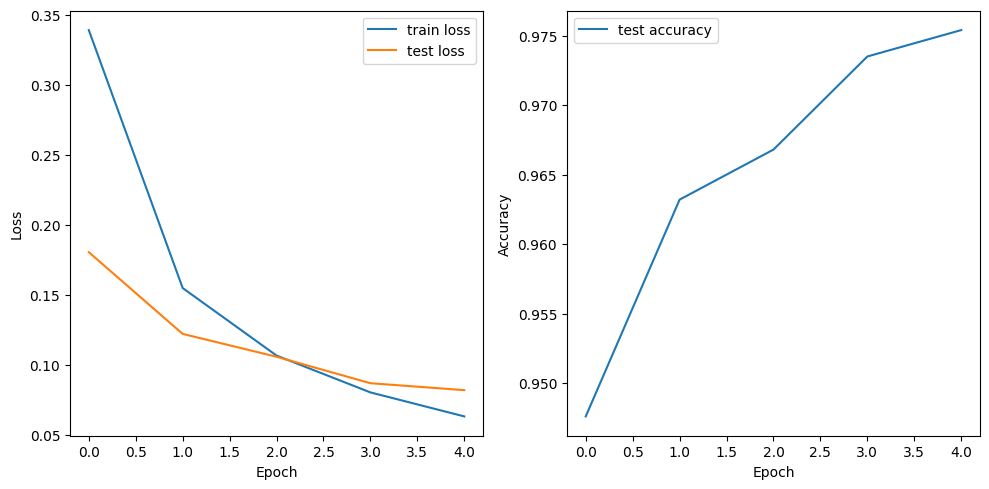

In [7]:
plt.figure(figsize=(10, 5), tight_layout=True)
plt.subplot(1, 2, 1)
plt.plot(history['train'], label='train loss')
plt.plot(history['test_loss'], label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can also evaluate the trained model on the test set using the `evaluate` method of the Evaluator. (Remember that the method returns a dictionary of metric values.)

In [8]:
metrics = evaluator.evaluate(model)

print(f"Test accuracy: {metrics['accuracy']:.2%}")

Test accuracy: 97.54%


Sometimes, we may want to evaluate the model on a different metric or dataset. We can create a new instance of the Evaluator with the desired dataset and/or metrics, and then call the `evaluate` method. For example, we can compute the confusion matrix for the test set.

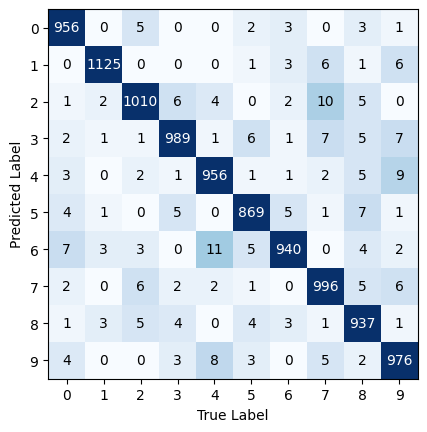

In [9]:
conf_matrix = ConfusionMatrix(10)

test_evaluator = Evaluator(test_ds, batch_size=64)
test_evaluator.add_metric('conf_matrix', conf_matrix)
test_evaluator.evaluate(model)

conf_matrix.plot()